<a href="https://colab.research.google.com/github/lkarjun/fastai-workouts/blob/master/Lesson_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package

In [2]:
!pip install fastai==2.5.3

     |████████████████████████████████| 189 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
from fastai.vision.all import *

# ResNets

In [2]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_items = get_image_files,
      splitter = GrandparentSplitter(valid_name = 'val'),
      get_y = parent_label,
      item_tfms = Resize(presize),
      batch_tfms = [*aug_transforms(min_scale=.5, size = resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs = 128)

In [3]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


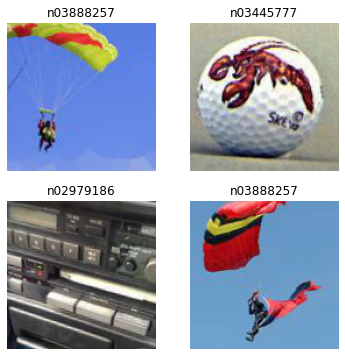

In [4]:
dls.show_batch(max_n = 4)

In [5]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [6]:
def get_learner(m):
  return Learner(dls, m, 
                 loss_func = nn.CrossEntropyLoss(), 
                 metrics = accuracy).to_fp16()

In [9]:
learn = get_learner(get_model())

SuggestedLRs(valley=0.004365158267319202)

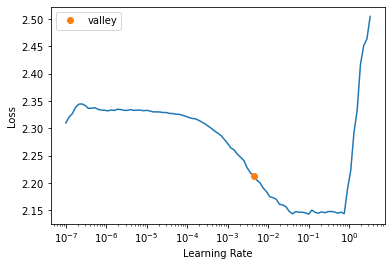

In [10]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(5, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.850497,1.921444,0.382166,00:26
1,1.535193,1.496399,0.510318,00:26
2,1.312157,1.338008,0.565350,00:26
3,1.142653,1.096311,0.655032,00:26
4,1.037617,1.060960,0.668025,00:26


## Building a Modern CNN: ResNet

### Skip connections

In [16]:
class ResBlock(nn.Module):
  def __init__(self, input, filters):
    self.convs = nn.Sequential(
                  ConvLayer(input, filters),
                  ConvLayer(filters, filters, norm_type=NormType.BatchZero)
            )
    
  def forward(self, x): return x + self.convs(x)